# Electric Vehicle Route Optimization in NYC

## Project Overview
This notebook demonstrates a machine learning approach to optimizing electric vehicle routes in New York City, considering multiple factors like energy consumption, congestion, and route efficiency.

### Key Objectives
- Develop a graph neural network for route optimization
- Incorporate multiple optimization metrics
- Create a probabilistic route selection method

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
import numpy as np
import osmnx as ox
import matplotlib.pyplot as plt


## Graph Neural Network Model for Route Optimization
We'll create a neural network that can learn route characteristics


In [2]:
class EVRouteOptimizer(nn.Module):
    def __init__(self, num_nodes, embedding_dim=64):
        super(EVRouteOptimizer, self).__init__()
        
        # Node feature embedding layer
        self.node_embedding = nn.Embedding(num_nodes, embedding_dim)
        
        # Graph convolution layers
        self.conv1 = nn.Linear(embedding_dim, embedding_dim)
        self.conv2 = nn.Linear(embedding_dim, embedding_dim)
        
        # Output layers for different optimization objectives
        self.energy_predictor = nn.Linear(embedding_dim, 1)
        self.congestion_predictor = nn.Linear(embedding_dim, 1)
        self.route_scorer = nn.Linear(embedding_dim, 1)
    
    def forward(self, nodes, edges):
        # Embed nodes
        node_features = self.node_embedding(nodes)
        
        # Graph convolution layers (simplified representation)
        x = F.relu(self.conv1(node_features))
        x = F.relu(self.conv2(x))
        
        # Predict different route characteristics
        energy_scores = self.energy_predictor(x)
        congestion_scores = self.congestion_predictor(x)
        route_scores = self.route_scorer(x)
        
        return energy_scores, congestion_scores, route_scores

In [3]:
# %% Load NYC Road Network
# Load NYC road network with OSMnx
nyc_graph = ox.graph_from_place('New York City, New York, USA', network_type='drive')

# Add synthetic features for demonstration
for (u, v, k, data) in nyc_graph.edges(keys=True, data=True):
    data['congestion'] = np.random.uniform(0.5, 2.0)
    data['energy_cost'] = np.random.uniform(0.1, 1.0)

In [4]:
# Precompute PageRank (this is typically the most time-consuming step)
pagerank_dict = nx.pagerank(nyc_graph)

In [5]:
nodes = list(nyc_graph.nodes())
node_to_index = {node: idx for idx, node in enumerate(nodes)}

In [6]:
node_features = []
for node in nyc_graph.nodes():
    node_features.append([
        nyc_graph.degree(node),  # Degree
        pagerank_dict[node],     # Precomputed PageRank
        nyc_graph.nodes[node].get('elevation', 0)  # Elevation
    ])
node_features_tensor = torch.tensor(node_features, dtype=torch.float32)

In [7]:
edge_features = []
for (u, v, data) in nyc_graph.edges(data=True):
    edge_features.append([
        data.get('length', 0),
        data.get('speed_limit', 30),
        data.get('congestion', 1.0)
    ])

In [8]:
edge_features_tensor = torch.tensor(edge_features, dtype=torch.float32)

In [9]:
# %% Initialize Route Optimizer Model
num_nodes = len(nodes)
model = EVRouteOptimizer(num_nodes)


# Select start and end nodes
start_node = nodes[len(nodes)//4]  # First quarter of nodes
end_node = nodes[3*len(nodes)//4]  # Last quarter of nodes

In [10]:
# Perform route optimization
energy_scores, congestion_scores, route_scores = model(
    torch.arange(num_nodes), 
    edge_features_tensor
)

In [11]:
# Combine scores with custom weighting
combined_scores = (
    0.4 * energy_scores + 
    0.3 * (-congestion_scores) + 
    0.3 * route_scores
)

Optimized Route: [42855624]


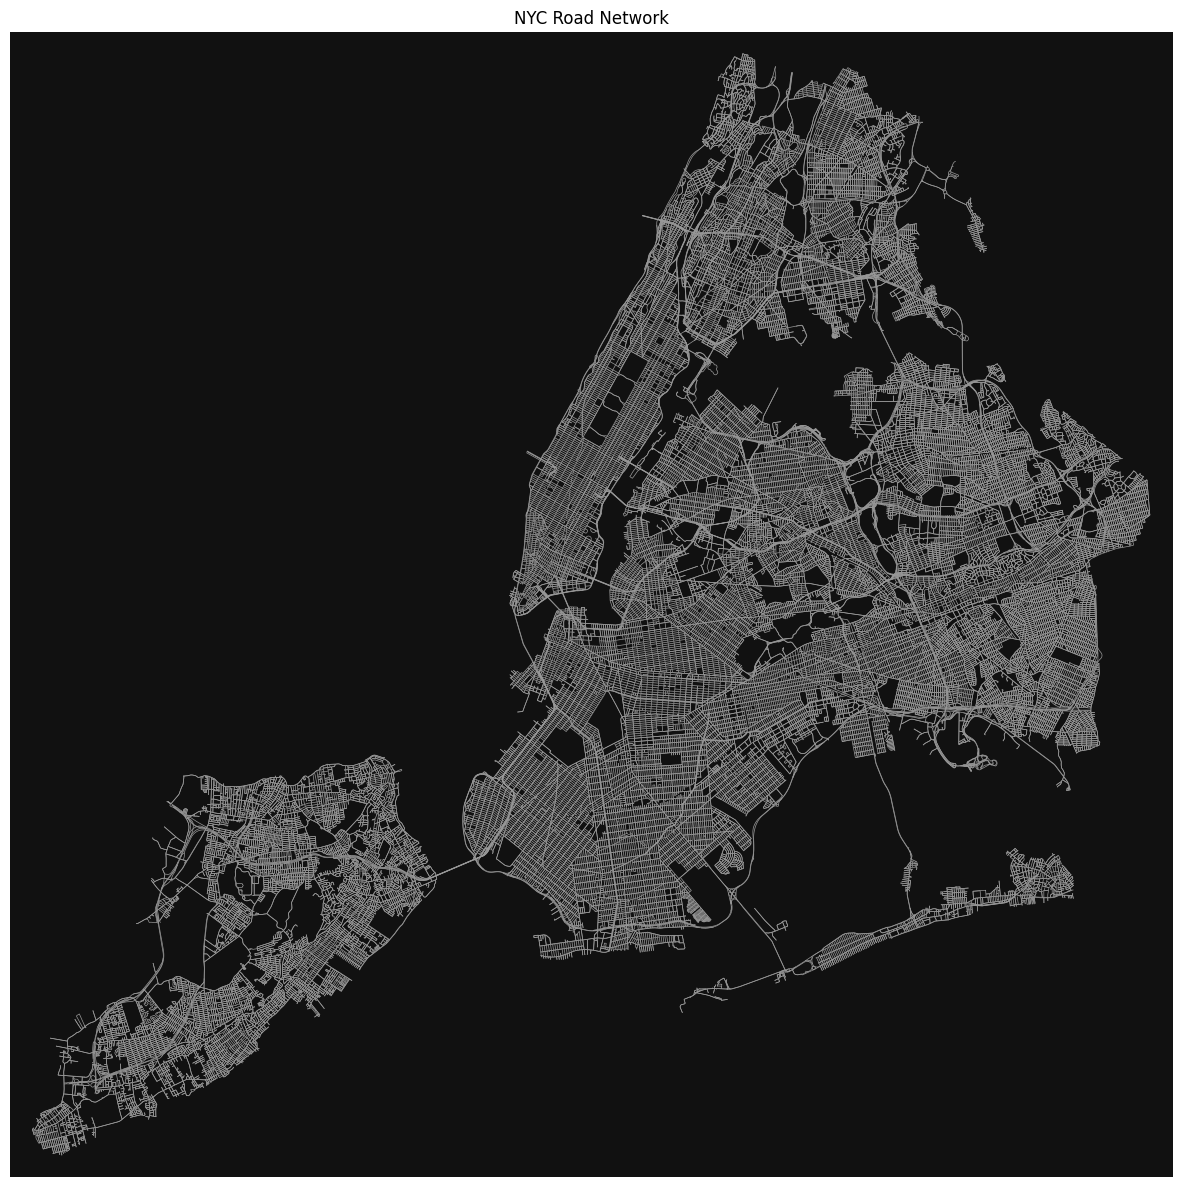

In [12]:
# Ensure combined_scores is 1D and has enough unique entries
combined_scores = combined_scores.squeeze()

# Adjust route sampling to match available probabilities
num_route_samples = min(5, len(combined_scores))

# Probabilistic route selection
route_probabilities = F.softmax(combined_scores, dim=0)
sampled_routes = torch.multinomial(route_probabilities, num_route_samples, replacement=False)

# Select best route
best_route_index = sampled_routes[torch.argmax(combined_scores[sampled_routes])]
best_route = [nodes[best_route_index]]
print("Optimized Route:", best_route)

# Visualization
fig, ax = ox.plot_graph(nyc_graph, node_size=0, edge_linewidth=0.5, 
                        figsize=(15, 15), show=False, close=False)
plt.title("NYC Road Network")
plt.show()

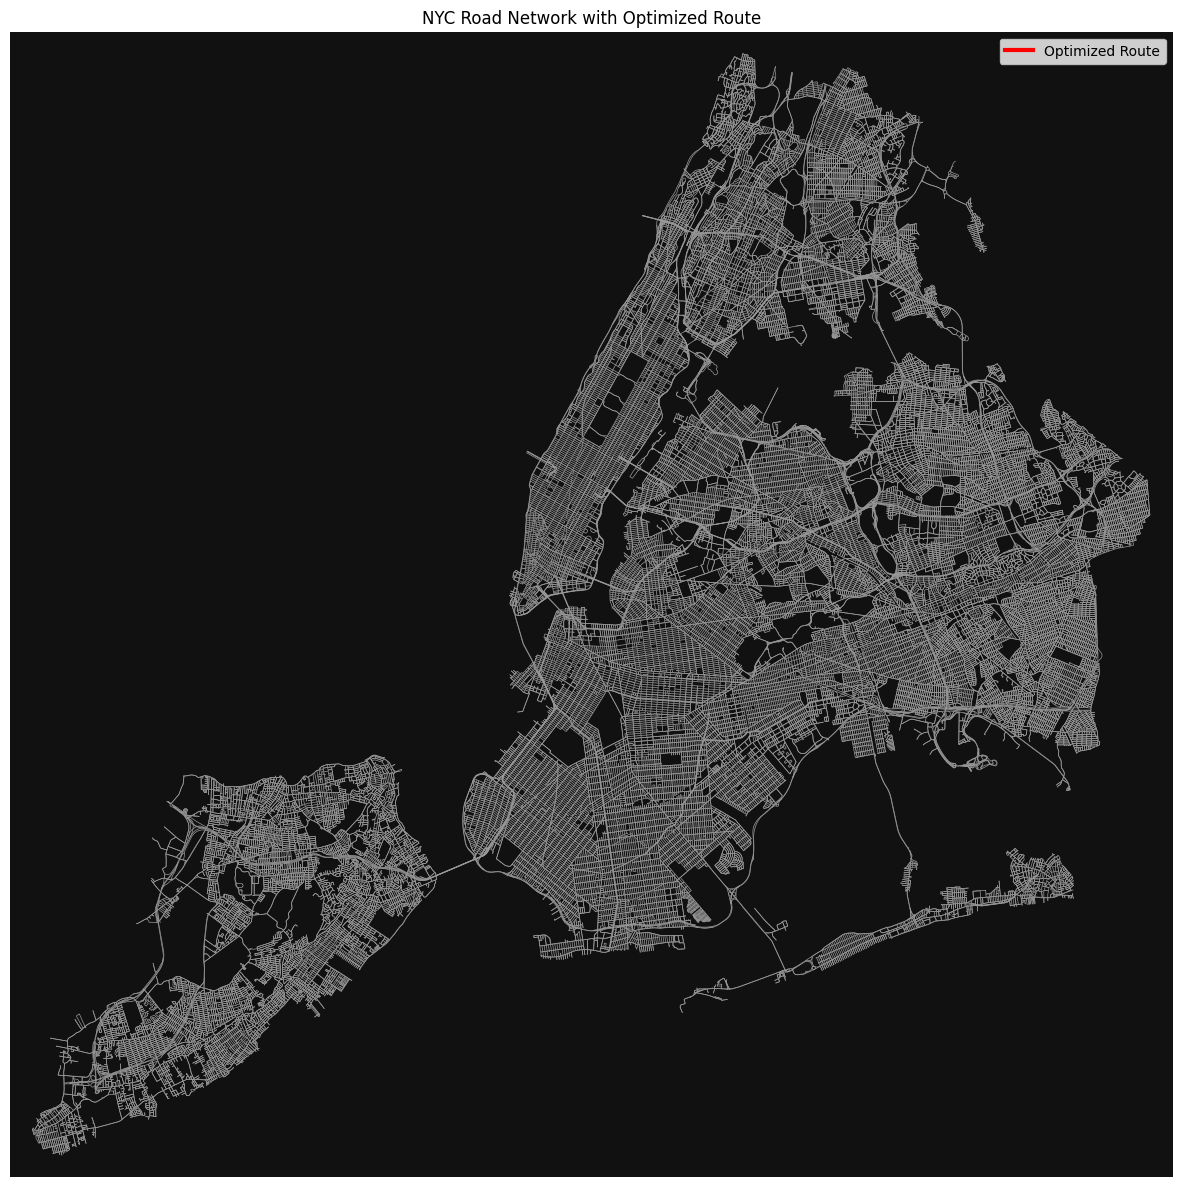

Optimized Route Nodes: [42855624]
Number of nodes in route: 1


In [13]:
# Prepare for route visualization
# Convert nodes to graph coordinates for plotting
node_coords = {node: (nyc_graph.nodes[node]['y'], nyc_graph.nodes[node]['x']) for node in best_route}
# Visualization with route highlighting
fig, ax = ox.plot_graph(nyc_graph, 
                        node_size=0, 
                        edge_linewidth=0.5, 
                        figsize=(15, 15), 
                        show=False, 
                        close=False)
# Highlight the best route
route_coords = [node_coords[node] for node in best_route]
ax.plot([coord[1] for coord in route_coords], 
        [coord[0] for coord in route_coords], 
        color='red', 
        linewidth=3, 
        zorder=5, 
        label='Optimized Route')
plt.title("NYC Road Network with Optimized Route")
plt.legend()
plt.show()
# Print route details
print("Optimized Route Nodes:", best_route)
print("Number of nodes in route:", len(best_route))